# Fake News Detection : Fake or Real Dataset

https://www.kaggle.com/datasets/jillanisofttech/fake-or-real-news

## Imports

In [1]:
import os
import re
import string
import pickle
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import textstat
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import gensim.downloader as api
from gensim.models import KeyedVectors

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/onyxia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/onyxia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/onyxia/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/onyxia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## 1. Load data

In [7]:
df_for = pd.read_csv("data/fake_or_real_news.csv")
# Drop first column
df_for = df_for.drop(df_for.columns[0], axis=1)
# Label 0 for fake news and label 1 for real news
df_for["label"] = df_for["label"].map({"FAKE": 0, "REAL": 1})
# Split the data
X = df_for["text"]
y = df_for["label"]

In [9]:
df_for.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


In [10]:
df_for.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 148.6+ KB


## 2. Data visualization

#### Distribution of Fake/Real news

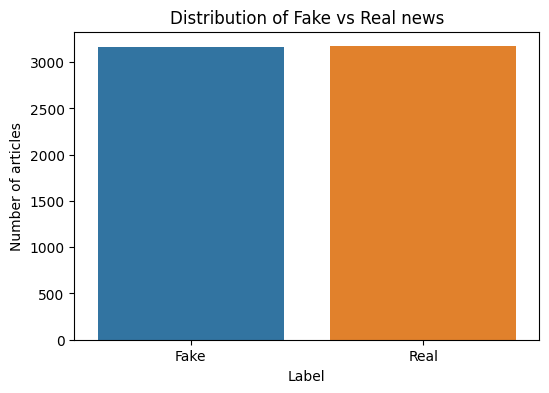

In [11]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_for, x="label", hue="label", legend=False)
plt.title("Distribution of Fake vs Real news")
plt.xlabel("Label")
plt.ylabel("Number of articles")
plt.xticks(ticks=[0, 1], labels=["Fake", "Real"])
plt.show()

In [12]:
df_for["label"].value_counts()

label
1    3171
0    3164
Name: count, dtype: int64

#### Article length distribution (in number of words)

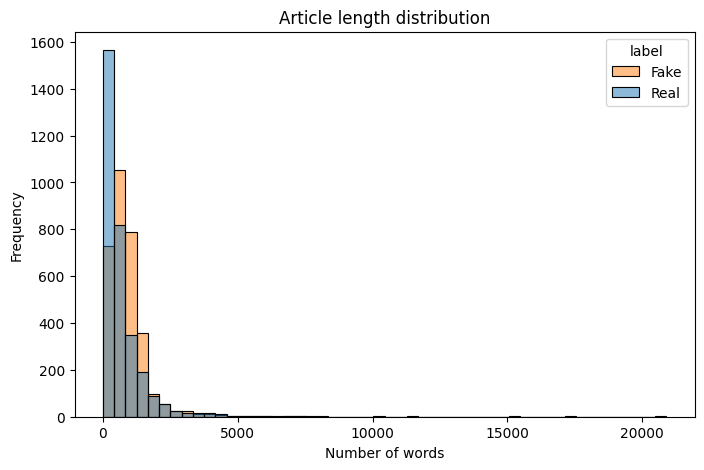

In [ ]:
df_for["article_length"] = df_for["text"].fillna('').apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(data=df_for, x="article_length", hue="label", bins=50)
plt.title("Article length distribution")
plt.legend(title="label", labels=["Fake", "Real"])
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

#### Title length distribution (in number of words)

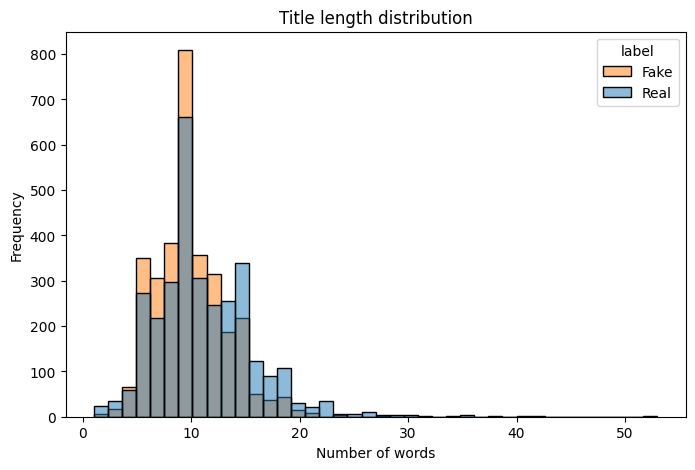

In [ ]:
df_for["title_length"] = df_for["title"].fillna('').apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(data=df_for, x="title_length", hue="label", bins=40)
plt.title("Title length distribution")
plt.legend(title="label", labels=["Fake", "Real"])
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

#### Word Cloud of text in Fake vs Real news

In [17]:
def clean_text(text):
    """
    Function to clean text and remove stopwords
    """
    text = re.sub(r"\W+", " ", text.lower())  # remove special caracters and lowercase
    stop_words = stopwords.words("english")
    filtered_tokens = [word for word in text.split() if word not in stop_words and len(word) > 2]
    return ' '.join(filtered_tokens)

In [18]:
df_for["text_cleaned"] = df_for["text"].apply(clean_text)

fake_text = " ".join(text for text in df_for.loc[df_for["label"] == 0, "text_cleaned"])
real_text = " ".join(text for text in df_for.loc[df_for["label"] == 1, "text_cleaned"])

# Word Clouds
fake_text_wc = WordCloud(background_color="white", width=800, height=400, random_state=42).generate(fake_text)
real_text_wc = WordCloud(background_color="white", width=800, height=400, random_state=42).generate(real_text)

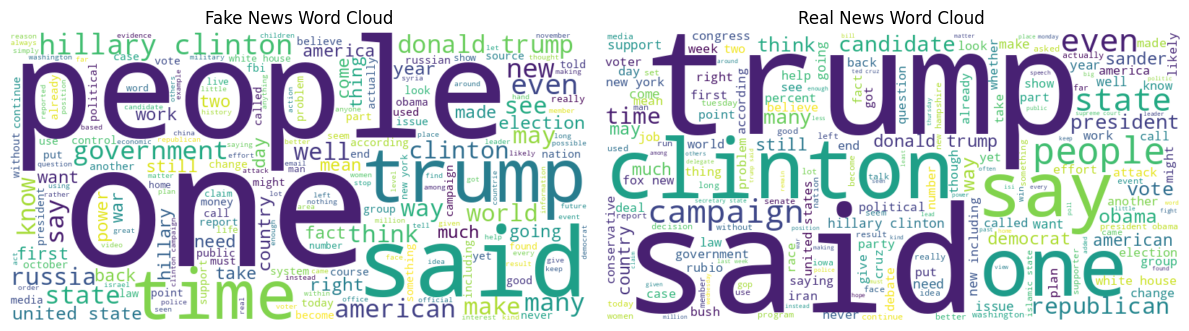

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(fake_text_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Fake News Word Cloud")

plt.subplot(1, 2, 2)
plt.imshow(real_text_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Real News Word Cloud")

plt.tight_layout()
plt.show()

## 3. Preprocessing 

In [20]:
def preprocessing_full(text):
    """
    Preprocessing function for models using Bag of Words and TF-IDF (with lemmatization).
    """
    # Lowercase
    text = text.lower()   
    # Remove URLs and Twitter handles
    text = re.sub(r"http\S+|www\S+|https\S+|@\w+", "", text) 
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)  
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    # Lemmatize and remove stopwords
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words("english")
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])    
    return text

In [21]:
def preprocessing_light(text):
    """
    Preprocessing function for models using Word2Vec and BERT (without lemmatization).
    """
    # Lowercase
    text = text.lower()   
    # Remove URLs and Twitter handles
    text = re.sub(r"http\S+|www\S+|https\S+|@\w+", "", text) 
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)  
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [22]:
# Apply full preprocessing
X_preprocessed_full = X.apply(preprocessing_full)

In [23]:
# Apply light preprocessing
X_preprocessed_light = X.apply(preprocessing_light)

## 4. Feature extraction

### 4.1. Bag of Words

In [24]:
def get_bow_features(X):
    """
    Extract Bag-of-Words features.
    """
    vectorizer = CountVectorizer(max_features=5000)
    X_bow = vectorizer.fit_transform(X)
    return X_bow, vectorizer

In [25]:
X_bow, bow_vectorizer = get_bow_features(X_preprocessed_full)

In [ ]:
# Save to pickle
with open("features/FoR/BoW_features.pkl", "wb") as f:
    pickle.dump(X_bow, f)

### 4.2. TF-IDF

In [26]:
def get_tfidf_features(X):
    """
    Extract TF-IDF features.
    """
    tfidf = TfidfVectorizer(max_features=5000)
    X_tfidf = tfidf.fit_transform(X)
    return X_tfidf, tfidf

In [27]:
X_tfidf, tfidf_vectorizer = get_tfidf_features(X_preprocessed_full)

In [ ]:
# Save to pickle
with open("features/FoR/TF-IDF_features.pkl", "wb") as f:
    pickle.dump(X_tfidf, f)

### 4.3. Word2Vec

In [28]:
def load_word2vec_model(path="word2vec-google-news-300.kv"):
    """
    Load or download the Word2Vec Google News model.
    """
    if os.path.exists(path):
        model = KeyedVectors.load(path)
    else:
        print("Downloading Word2Vec model...")
        model = api.load("word2vec-google-news-300")
        model.save(path)
    print(f"Word2Vec loaded! Vocab size: {len(model.key_to_index)}")
    return model

In [29]:
def get_word2vec_embeddings(texts, model, save_path, vector_size=300):
    """
    Compute or load Word2Vec embeddings from preprocessed texts.
    """    
    if os.path.exists(save_path):
        print("Loading Word2Vec embeddings from cache.")
        with open(save_path, "rb") as f:
            return pickle.load(f)

    print("Computing Word2Vec embeddings...")
    
    def doc_to_vec(doc):
        tokens = doc.split()
        vectors = [model[word] for word in tokens if word in model.key_to_index]
        return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

    embeddings = np.array([doc_to_vec(text) for text in texts])

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, "wb") as f:
        pickle.dump(embeddings, f)
    
    return embeddings

In [30]:
# Load Word2Vec model
word2vec_model = load_word2vec_model()

Word2Vec loaded! Vocab size: 3000000


In [ ]:
# Extract or load embeddings
X_word2vec = get_word2vec_embeddings(X_preprocessed_light.tolist(), word2vec_model, "features/FoR/Word2Vec_features.pkl")

Computing Word2Vec embeddings...


In [32]:
X_word2vec.shape

(6335, 300)

### 4.4. BERT

In [33]:
# Load tokenizer and model once
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [34]:
def get_bert_embeddings_batch(texts, save_path, batch_size=32):
    """
    Compute BERT embeddings in batches or load from pickle if available.
    """
    if os.path.exists(save_path):
        print("Loading BERT embeddings from cache.")
        with open(save_path, 'rb') as f:
            return pickle.load(f)
        
    print("Computing BERT embeddings in batches...")
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy()) 
    X_bert = np.vstack(embeddings)

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, 'wb') as f:
        pickle.dump(X_bert, f)
        
    return X_bert

In [ ]:
X_bert = get_bert_embeddings_batch(X_preprocessed_light.tolist(), save_path="features/FoR/BERT_features.pkl")

Computing BERT embeddings in batches...


In [36]:
X_bert.shape

(6335, 768)

### 4.5. Linguistic Cues

In [37]:
# Dictionnaires de pronoms, conjonctions, etc.
PERSONAL_PRONOUNS = {"i", "we", "she", "he", "him", "her"}
FIRST_PERSON_SINGULAR = {"i", "me"}
FIRST_PERSON_PLURAL = {"we", "us"}
SECOND_PERSON = {"you", "your"}
THIRD_PERSON_SINGULAR = {"she", "he", "her", "him"}
IMPERSONAL_PRONOUNS = {"it", "that", "anything"}
ARTICLES = {"a", "an", "the"}
PREPOSITIONS = {"above", "below", "under", "into", "of", "at", "on", "by", "with", "about", "against", "between", "among", "through", "during", "before", "after", "over", "under", "around", "near"}
AUXILIARY_VERBS = {"be", "am", "is", "are", "was", "were", "being", "been", "have", "has", "had", "having", "do", "does", "did"}
COMMON_ADVERBS = {"just", "usually", "even", "also", "too", "very", "often", "however"}
CONJUNCTIONS = {"and", "but", "or", "yet", "so", "for", "nor", "although", "because", "since", "unless", "until", "while"}
NEGATIONS = {"no", "never", "not"}
COMMON_VERBS = {"run", "walk", "eat", "go", "see", "say", "think"}
COMMON_ADJECTIVES = {"better", "greater", "larger", "smaller", "good", "bad", "happy", "sad"}

PUNCTUATION_MAP = {
    '.': 'full_stop',
    ',': 'comma',
    ':': 'colon',
    ';': 'semicolon',
    '?': 'question_mark',
    '!': 'exclamation_mark',
    '-': 'dash',
    "'": 'apostrophe',
    '(': 'bracket', ')': 'bracket'
}

In [38]:
def extract_linguistic_features(text):
    tokens = word_tokenize(text)
    lower_tokens = [t.lower() for t in tokens]
    num_words = len(tokens)
    num_sents = len(sent_tokenize(text))
    num_syllables = textstat.syllable_count(text)
    long_words = [word for word in tokens if len(word) > 6]
    all_caps = [word for word in tokens if word.isupper() and len(word) > 1]
    unique_words = set(lower_tokens)

    # Punctuation counts
    punct_counts = {name: text.count(symb) for symb, name in PUNCTUATION_MAP.items()}

    def percent(word_set):
        return 100 * sum(1 for word in lower_tokens if word in word_set) / num_words if num_words > 0 else 0

    def percent_pos(pos_prefix):
        pos_tags = pos_tag(tokens)
        return 100 * sum(1 for _, tag in pos_tags if tag.startswith(pos_prefix)) / num_words if num_words > 0 else 0

    features = {
        'word_count': num_words,
        'syllable_count': num_syllables,
        'sentence_count': num_sents,
        'words_per_sentence': num_words / num_sents if num_sents > 0 else 0,
        'long_words_count': len(long_words),
        'all_caps_count': len(all_caps),
        'unique_words_count': len(unique_words),
        'personal_pronouns_percent': percent(PERSONAL_PRONOUNS),
        'first_person_singular_percent': percent(FIRST_PERSON_SINGULAR),
        'first_person_plural_percent': percent(FIRST_PERSON_PLURAL),
        'second_person_percent': percent(SECOND_PERSON),
        'third_person_singular_percent': percent(THIRD_PERSON_SINGULAR),
        'impersonal_pronouns_percent': percent(IMPERSONAL_PRONOUNS),
        'articles_percent': percent(ARTICLES),
        'prepositions_percent': percent(PREPOSITIONS),
        'auxiliary_verbs_percent': percent(AUXILIARY_VERBS),
        'common_adverbs_percent': percent(COMMON_ADVERBS),
        'conjunctions_percent': percent(CONJUNCTIONS),
        'negations_percent': percent(NEGATIONS),
        'common_verbs_percent': percent(COMMON_VERBS),
        'common_adjectives_percent': percent(COMMON_ADJECTIVES),
        'concrete_figures_percent': 100 * len(re.findall(r'\b\d+(?:\.\d+)?\b', text)) / num_words if num_words > 0 else 0,
        'punctuation_count': sum(punct_counts.values())
    }

    # Add individual punctuation counts
    features.update({f"{key}_count": val for key, val in punct_counts.items()})
    
    return features

In [39]:
tqdm.pandas()  # Progress bar
X_linguistic = X.progress_apply(extract_linguistic_features).apply(pd.Series)

100%|██████████| 6335/6335 [00:49<00:00, 127.13it/s]


In [40]:
X_linguistic

,word_count,syllable_count,sentence_count,words_per_sentence,long_words_count,all_caps_count,unique_words_count,personal_pronouns_percent,first_person_singular_percent,first_person_plural_percent,...,punctuation_count,full_stop_count,comma_count,colon_count,semicolon_count,question_mark_count,exclamation_mark_count,dash_count,apostrophe_count,bracket_count
0,1473.0,2082.0,87.0,16.931034,300.0,40.0,535.0,2.443992,0.000000,0.135777,...,106.0,85.0,17.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0
1,517.0,691.0,26.0,19.884615,100.0,2.0,279.0,1.934236,0.000000,0.000000,...,55.0,28.0,19.0,3.0,0.0,0.0,0.0,4.0,0.0,1.0
2,484.0,693.0,16.0,30.250000,101.0,4.0,237.0,2.685950,0.413223,0.206612,...,43.0,24.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,498.0,705.0,17.0,29.294118,135.0,5.0,259.0,0.401606,0.000000,0.000000,...,62.0,17.0,28.0,4.0,0.0,0.0,1.0,4.0,3.0,5.0
4,376.0,458.0,21.0,17.904762,71.0,1.0,179.0,3.457447,0.265957,1.595745,...,57.0,21.0,17.0,0.0,0.0,0.0,2.0,4.0,13.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6330,726.0,1054.0,27.0,26.888889,196.0,9.0,264.0,1.652893,0.000000,0.137741,...,82.0,30.0,22.0,0.0,0.0,0.0,1.0,8.0,21.0,0.0
6331,2594.0,3916.0,49.0,52.938776,687.0,56.0,1004.0,0.501157,0.077101,0.308404,...,343.0,145.0,108.0,4.0,15.0,1.0,0.0,44.0,0.0,26.0
6332,2137.0,3299.0,100.0,21.370000,575.0,17.0,753.0,1.450632,0.233973,0.514740,...,205.0,103.0,79.0,4.0,0.0,6.0,0.0,10.0,1.0,2.0
6333,1313.0,1908.0,40.0,32.825000,301.0,12.0,538.0,1.599391,0.456969,0.152323,...,144.0,66.0,71.0,3.0,0.0,0.0,0.0,2.0,1.0,1.0


In [ ]:
# Save to pickle
with open("features/FoR/Linguistic_features.pkl", "wb") as f:
    pickle.dump(X_linguistic, f)

## 5. Model training and evaluation

In [42]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [43]:
def train_evaluate_models(features_dict, y, output_dir="models/", cv_folds=5, random_state=42, save_models=True):
    models = {
        "AdaBoost": AdaBoostClassifier(random_state=random_state),
        "GradientBoosting": GradientBoostingClassifier(random_state=random_state),
        "LogisticRegression": LogisticRegression(max_iter=1000, random_state=random_state),
        "MLPClassifier": MLPClassifier(max_iter=300, random_state=random_state),
        "RandomForest": RandomForestClassifier(random_state=random_state),
    }

    scoring = {
        "accuracy": make_scorer(accuracy_score),
        "precision": make_scorer(precision_score, average="weighted", zero_division=0),
        "recall": make_scorer(recall_score, average="weighted", zero_division=0),
        "f1": make_scorer(f1_score, average="weighted", zero_division=0),
    }

    results = []
    if save_models:
        os.makedirs(output_dir, exist_ok=True)

    for feature_name, X in features_dict.items():
        for model_name, model in models.items():
            print(f"Running cross-validation for {feature_name} and {model_name}")
            cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
            scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
            results.append({
                "feature": feature_name,
                "model": model_name,
                "accuracy": np.mean(scores["test_accuracy"]),
                "precision": np.mean(scores["test_precision"]),
                "recall": np.mean(scores["test_recall"]),
                "f1_score": np.mean(scores["test_f1"]),
            })
            # Print scores
            print(f"Accuracy: {np.mean(scores["test_accuracy"]):.4f}")
            print(f"Precision: {np.mean(scores["test_precision"]):.4f}")
            print(f"Recall: {np.mean(scores["test_recall"]):.4f}")
            print(f"F1 Score: {np.mean(scores["test_f1"]):.4f}")
            print('\n')

            if save_models:
                model.fit(X, y)
                filename = os.path.join(output_dir, f"{feature_name}_{model_name}.joblib")
                joblib.dump(model, filename)

    return pd.DataFrame(results)

In [44]:
features_dict = {
    'BoW': X_bow,
    'TF-IDF': X_tfidf,
    'Word2Vec': X_word2vec,
    'BERT': X_bert,
    'Linguistic': X_linguistic,
}

In [45]:
results_df = train_evaluate_models(features_dict, y, output_dir="models/FoR")

Running cross-validation for BoW and AdaBoost
Accuracy: 0.8606
Precision: 0.8630
Recall: 0.8606
F1 Score: 0.8604


Running cross-validation for BoW and GradientBoosting
Accuracy: 0.8917
Precision: 0.8929
Recall: 0.8917
F1 Score: 0.8916


Running cross-validation for BoW and LogisticRegression
Accuracy: 0.9168
Precision: 0.9173
Recall: 0.9168
F1 Score: 0.9168


Running cross-validation for BoW and MLPClassifier
Accuracy: 0.9162
Precision: 0.9168
Recall: 0.9162
F1 Score: 0.9162


Running cross-validation for BoW and RandomForest
Accuracy: 0.9132
Precision: 0.9133
Recall: 0.9132
F1 Score: 0.9132


Running cross-validation for TF-IDF and AdaBoost
Accuracy: 0.8579
Precision: 0.8586
Recall: 0.8579
F1 Score: 0.8579


Running cross-validation for TF-IDF and GradientBoosting
Accuracy: 0.8982
Precision: 0.8989
Recall: 0.8982
F1 Score: 0.8981


Running cross-validation for TF-IDF and LogisticRegression
Accuracy: 0.9181
Precision: 0.9190
Recall: 0.9181
F1 Score: 0.9180


Running cross-validation f

/usr/local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptro

Accuracy: 0.9089
Precision: 0.9092
Recall: 0.9089
F1 Score: 0.9089




/usr/local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Running cross-validation for Word2Vec and RandomForest
Accuracy: 0.8666
Precision: 0.8681
Recall: 0.8666
F1 Score: 0.8665


Running cross-validation for BERT and AdaBoost
Accuracy: 0.8158
Precision: 0.8161
Recall: 0.8158
F1 Score: 0.8157


Running cross-validation for BERT and GradientBoosting
Accuracy: 0.8530
Precision: 0.8532
Recall: 0.8530
F1 Score: 0.8530


Running cross-validation for BERT and LogisticRegression
Accuracy: 0.8939
Precision: 0.8942
Recall: 0.8939
F1 Score: 0.8939


Running cross-validation for BERT and MLPClassifier
Accuracy: 0.9066
Precision: 0.9070
Recall: 0.9066
F1 Score: 0.9065


Running cross-validation for BERT and RandomForest
Accuracy: 0.8407
Precision: 0.8413
Recall: 0.8407
F1 Score: 0.8407


Running cross-validation for Linguistic and AdaBoost
Accuracy: 0.8106
Precision: 0.8113
Recall: 0.8106
F1 Score: 0.8105


Running cross-validation for Linguistic and GradientBoosting
Accuracy: 0.8420
Precision: 0.8422
Recall: 0.8420
F1 Score: 0.8420


Running cross-val

/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy: 0.7975
Precision: 0.7981
Recall: 0.7975
F1 Score: 0.7974




/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Running cross-validation for Linguistic and MLPClassifier
Accuracy: 0.7831
Precision: 0.8120
Recall: 0.7831
F1 Score: 0.7771


Running cross-validation for Linguistic and RandomForest
Accuracy: 0.8502
Precision: 0.8506
Recall: 0.8502
F1 Score: 0.8502




In [46]:
results_df

,feature,model,accuracy,precision,recall,f1_score
0,BoW,AdaBoost,0.860616,0.862988,0.860616,0.860396
1,BoW,GradientBoosting,0.891713,0.892892,0.891713,0.891635
2,BoW,LogisticRegression,0.916811,0.917315,0.916811,0.916788
3,BoW,MLPClassifier,0.916180,0.916805,0.916180,0.916150
4,BoW,RandomForest,0.913181,0.913312,0.913181,0.913174
5,TF-IDF,AdaBoost,0.857932,0.858623,0.857932,0.857867
6,TF-IDF,GradientBoosting,0.898185,0.898886,0.898185,0.898143
7,TF-IDF,LogisticRegression,0.918074,0.919007,0.918074,0.918031
8,TF-IDF,MLPClassifier,0.928019,0.928410,0.928019,0.928003
9,TF-IDF,RandomForest,0.914601,0.914727,0.914601,0.914595


In [47]:
results_df.to_csv("results/FoR_results.csv", index=False)